# Part 3 — Data Quality

## Links
- **Live updated app:** https://ind320-project-work-nonewthing.streamlit.app/
- **Repo:** https://github.com/TaoM29/IND320-dashboard-basics



## Scope
This part extends the project with data-quality analysis on weather (Open-Meteo ERA5) and production (Elhub) time series, plus diagnostics plots that surface anomalies and periodic structure.


# AI Usage

Used an ChatGPT 5 as a coding and troubleshooting partner. It helped me speed up routine tasks: proposing robust outlier methods (plot_temperature_outliers_dct, plot_precip_anomalies_lof with LOF stabilization), clarifying warnings (working-directory paths, pandas, annyoing warning messages related to depriciation etc). I reviewed and edited all code, selected parameters, and validated outputs (row counts, plots, anomaly rates). Final decisions, parameter choices, and interpretations are my own.

# Work Log

Data prep. I defined a table for the five Norwegian price areas (Oslo, Kristiansand, Trondheim, Tromsø and Bergen): (price_area, city, longitude, latitude) and used those coordinates as single-point representatives. I then wrote download_era5_to_df(longitude, latitude, year) to pull ERA5 historical reanalysis from Open-Meteo for a given year. The function returns a DataFrame with exactly the columns used in Part 1 (time, temperature, precipitation, wind speed, gusts, direction), so downstream code stays consistent. I verified Bergen 2019 completeness with a simple row-count (~8760 hours) and checked timezone handling (Europe/Oslo) to avoid DST gaps.

Temperature outliers (DCT + SPC). I created plot_temperature_outliers_dct(...) that:
- builds a seasonal baseline with a low-pass DCT (keep first K% coefficients),
- computes seasonally adjusted temperature variations (SATV = obs − baseline),
- estimates robust dispersion via MAD → σᵣ, and
- plots SPC bands baseline ± k·σᵣ (only temperature is plotted; SATV is used internally). Parameters: cutoff_fraction (default 0.10) and k_sigma (default 3.0). Outliers are highlighted as points and a summary dict is returned. 

Precipitation anomalies (LOF). I implemented plot_precip_anomalies_lof(...) using Local Outlier Factor on univariate precipitation with contamination=0.01. Because hourly precip has many ties (zeros), I stabilized LOF with: more neighbors (n_neighbors=60), log1p transform, and a tiny zero-jitter (1e-6). The function returns the plot, a summary, and an anomalies table; results match the requested ~1% rate and flag expected spikes.

STL decomposition (production). For Elhub hourly production I wrote stl_decompose_elhub(...) (params: area, group, period, seasonal, trend, robust). Defaults target diurnal structure (period=24, seasonal=13, trend=365). The function returns four separate figures (Observed/Seasonal/Trend/Residual) and metadata. 

Spectrogram (production). I added plot_production_spectrogram(...) with parameters: area, group, window length, and overlap. Defaults: window_len=168, overlap=84, Hann window, PSD scaling. The plot shows a strong 24-hour band in summer for NO1/solar. 

Packaging. Each function returns both a plot and concise summaries so they can be reused in the notebook and Streamlit. Code blocks are commented and parameterized per assignment guidance.


In [98]:
# Necessary imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import display
from scipy.fftpack import dct, idct
import requests
import matplotlib.dates as mdates
from datetime import date
from sklearn.neighbors import LocalOutlierFactor
from statsmodels.tsa.seasonal import STL
from scipy.signal import spectrogram

In [79]:
# Representative cities for NO1–NO5 and their approximate city-center coordinates
rows = [
    # price_area, city, longitude, latitude
    ("NO1", "Oslo",         10.7461, 59.9127),
    ("NO2", "Kristiansand",  7.9956, 58.1467),
    ("NO3", "Trondheim",    10.3951, 63.4305),
    ("NO4", "Tromsø",       18.9551, 69.6489),
    ("NO5", "Bergen",        5.3242, 60.3930),  
]

df_price_areas = pd.DataFrame(
    rows, columns=["price_area", "city", "longitude", "latitude"]
)

df_price_areas


,price_area,city,longitude,latitude
0,NO1,Oslo,10.7461,59.9127
1,NO2,Kristiansand,7.9956,58.1467
2,NO3,Trondheim,10.3951,63.4305
3,NO4,Tromsø,18.9551,69.6489
4,NO5,Bergen,5.3242,60.3930


In [80]:
# Columns from Part 1 CSV
_CSV_COLUMNS = [
    "time",
    "temperature_2m (°C)",
    "precipitation (mm)",
    "wind_speed_10m (m/s)",
    "wind_gusts_10m (m/s)",
    "wind_direction_10m (°)",
]

# Map CSV columns -> Open-Meteo ERA5 hourly variable names
_VAR_MAP = {
    "temperature_2m (°C)": "temperature_2m",
    "precipitation (mm)": "precipitation",
    "wind_speed_10m (m/s)": "windspeed_10m",
    "wind_gusts_10m (m/s)": "windgusts_10m",
    "wind_direction_10m (°)": "winddirection_10m",
}


def download_era5_to_df(longitude: float, latitude: float, year: int, timezone: str = "Europe/Oslo") -> pd.DataFrame:
    """
    Download ERA5 historical reanalysis (Open-Meteo archive API) for a single location and year.
    Returns a DataFrame with the SAME columns as our Part 1 CSV.
    """

    start_date = f"{year}-01-01"
    end_date = f"{year}-12-31"
    if year == date.today().year:
        # Ensure we don't request future dates if running mid-year
        end_date = min(end_date, date.today().isoformat())

    url = "https://archive-api.open-meteo.com/v1/era5"
    hourly_vars = list(_VAR_MAP.values())

    params = {
        "latitude": latitude,
        "longitude": longitude,
        "start_date": start_date,
        "end_date": end_date,
        "hourly": hourly_vars,
        "timezone": timezone,
    }

    r = requests.get(url, params=params, timeout=60)
    r.raise_for_status()
    data = r.json()

    # Parse hourly block
    hourly = data.get("hourly", {})
    times = hourly.get("time", [])

    # Build DataFrame with CSV-matching columns/order
    df = pd.DataFrame({"time": pd.to_datetime(times)})

    for csv_col, api_var in _VAR_MAP.items():
        df[csv_col] = hourly.get(api_var, [None] * len(df))

    # Ensure monotonic time index and set dtype
    df = df.sort_values("time").reset_index(drop=True)
    return df


# Apply the function to Bergen for the year 2019.
bergen_2019 = download_era5_to_df(longitude=5.3242, latitude=60.3930, year=2019)

print(f"rows: {len(bergen_2019):}")
display(bergen_2019.head())

rows: 8760


,time,temperature_2m (°C),precipitation (mm),wind_speed_10m (m/s),wind_gusts_10m (m/s),wind_direction_10m (°)
0,2019-01-01 00:00:00,5.7,0.7,37.0,99.7,263
1,2019-01-01 01:00:00,5.8,0.2,41.0,107.3,278
2,2019-01-01 02:00:00,6.1,0.7,42.0,112.0,286
3,2019-01-01 03:00:00,6.3,0.5,40.9,105.8,298
4,2019-01-01 04:00:00,5.8,1.1,41.2,110.2,315


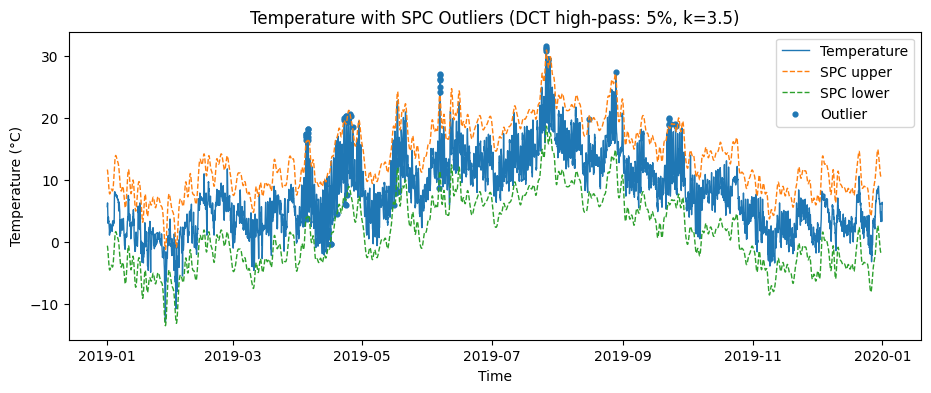

(                 time  temperature_2m (°C)      SATV
 0 2019-02-02 14:00:00                 -0.5  6.378833
 1 2019-04-04 12:00:00                 16.4  6.646718
 2 2019-04-04 13:00:00                 16.9  7.026664
 3 2019-04-04 14:00:00                 17.5  7.524481
 4 2019-04-04 15:00:00                 17.4  7.339709,
 {'n_points': 8760,
  'n_outliers': 58,
  'pct_outliers': 0.6621004566210046,
  'dct_low_frac': 0.05,
  'k_sigma': 3.5,
  'satv_median': -0.12235247399478086,
  'satv_robust_sigma': 1.7572549867311327})

In [81]:

# Function for Temperature with SPC outliers    
def plot_temperature_spc_with_dct(
    df: pd.DataFrame,
    time_col: str = "time",
    temp_col: str = "temperature_2m (°C)",
    dct_low_frac: float = 0.05,   # remove the lowest 5% frequencies (trend/seasonality)
    k_sigma: float = 3.5,         # robust "std dev" multiplier for SPC limits
):
    """
    Plots temperature vs time, computes SATV via DCT high-pass, draws SPC bounds,
    and colors outliers. Returns (fig, outliers_df, summary_dict).
    """
    s = df[temp_col].astype(float).to_numpy()
    t = pd.to_datetime(df[time_col])

    # DCT high-pass: remove the lowest-frequency components (including DC) 
    N = s.size
    S = dct(s, type=2, norm="ortho")
    k_cut = max(1, int(np.floor(dct_low_frac * N)))  # number of lowest freqs to zero
    S_hp = S.copy()
    S_hp[:k_cut] = 0.0
    satv = idct(S_hp, type=2, norm="ortho")          # SATV (high-frequency component)
    trend = s - satv                                 # low-frequency (seasonal/trend)

    # Robust statistics on SATV (NOT plot SATV) 
    satv_med = np.median(satv)
    mad = np.median(np.abs(satv - satv_med))
    robust_sigma = 1.4826 * mad if mad > 0 else np.std(satv)  # fallback if flat

    upper_satv = satv_med + k_sigma * robust_sigma
    lower_satv = satv_med - k_sigma * robust_sigma

    # Convert SATV bounds to temperature-scale SPC curves by adding trend
    upper_spc = trend + upper_satv
    lower_spc = trend + lower_satv

    # Outliers where SATV breaches bounds 
    outlier_mask = (satv > upper_satv) | (satv < lower_satv)
    outliers_df = pd.DataFrame({
        time_col: t[outlier_mask].to_numpy(),
        temp_col: s[outlier_mask],
        "SATV": satv[outlier_mask]
    }).sort_values(time_col).reset_index(drop=True)

    # Plot 
    fig, ax = plt.subplots(figsize=(11, 4))
    ax.plot(t, s, linewidth=1.0, label="Temperature")
    ax.plot(t, upper_spc, linestyle="--", linewidth=1.0, label="SPC upper")
    ax.plot(t, lower_spc, linestyle="--", linewidth=1.0, label="SPC lower")
    if outliers_df.shape[0] > 0:
        ax.scatter(outliers_df[time_col], outliers_df[temp_col], s=12, label="Outlier")

    ax.set_title(f"Temperature with SPC Outliers (DCT high-pass: {dct_low_frac:.0%}, k={k_sigma})")
    ax.set_xlabel("Time")
    ax.set_ylabel("Temperature (°C)")
    ax.legend(loc="best")

    # Summary 
    summary = {
        "n_points": int(N),
        "n_outliers": int(outliers_df.shape[0]),
        "pct_outliers": float(100 * outliers_df.shape[0] / max(1, N)),
        "dct_low_frac": float(dct_low_frac),
        "k_sigma": float(k_sigma),
        "satv_median": float(satv_med),
        "satv_robust_sigma": float(robust_sigma),
    }
    return fig, outliers_df, summary


# Usage: Bergen 2019 
fig, outliers_df, summary = plot_temperature_spc_with_dct(bergen_2019)
plt.show(fig)
outliers_df.head(), summary


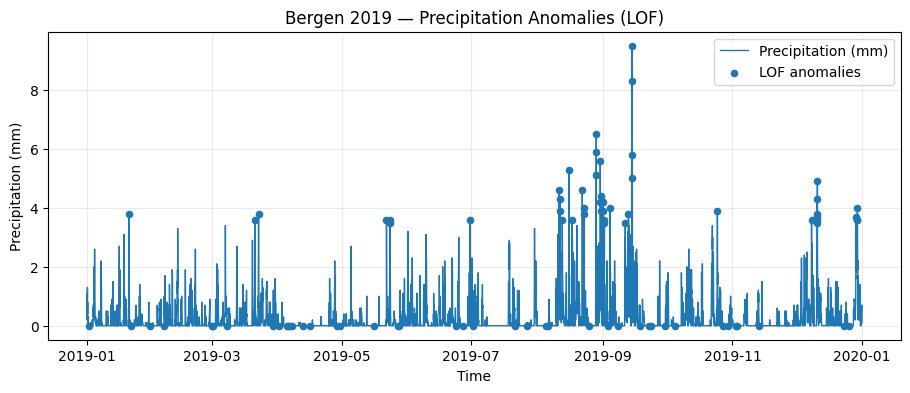

({'n_points': 8760,
  'n_anomalies': 88,
  'anomaly_pct': 1.004566210045662,
  'contamination': 0.01,
  'n_neighbors': 60,
  'log1p': True,
  'jitter_eps': 1e-06},
                    time  precipitation (mm)  lof_score
 26  2019-01-02 02:00:00                 0.0   1.196947
 477 2019-01-20 21:00:00                 3.8   1.267197
 494 2019-01-21 14:00:00                 0.0   1.325517
 711 2019-01-30 15:00:00                 0.0   1.125108
 869 2019-02-06 05:00:00                 0.0   1.172759)

In [82]:
# Function for Precipitation (LOF)
def plot_precip_anomalies_lof(
    df: pd.DataFrame,
    time_col: str = "time",
    precip_col: str = "precipitation (mm)",
    contamination: float = 0.01,
    n_neighbors: int = 60,           # number of neighbors for LOF
    jitter_eps: float = 1e-6,        # add tiny noise to exact zeros only
    use_log1p: bool = True,
    title: str | None = None
):
    s = df[[time_col, precip_col]].dropna().sort_values(time_col)
    t = pd.to_datetime(s[time_col].values)
    y = s[precip_col].astype(float).values.copy()

    # tie-break only exact zeros
    if jitter_eps and jitter_eps > 0:
        zmask = (y == 0.0)
        if zmask.any():
            rng = np.random.default_rng(0)
            y[zmask] = y[zmask] + rng.uniform(-jitter_eps, jitter_eps, size=zmask.sum())

    # stabilize heavy right tail
    if use_log1p:
        y = np.log1p(y)

    Y = y.reshape(-1, 1)

    # keep neighbors valid
    n_neighbors = int(min(max(5, n_neighbors), len(Y) - 1))

    lof = LocalOutlierFactor(
        n_neighbors=n_neighbors,
        contamination=contamination,
        novelty=False
    )
    y_pred = lof.fit_predict(Y)           # -1 = outlier
    scores = -lof.negative_outlier_factor_

    is_anom = (y_pred == -1)

    # plot original scale for readability
    fig, ax = plt.subplots(figsize=(11, 4.0))
    ax.plot(t, s[precip_col].values, lw=1.0, label="Precipitation (mm)")
    ax.scatter(t[is_anom], s[precip_col].values[is_anom], s=20, zorder=3, label="LOF anomalies")

    ax.set_xlabel("Time")
    ax.set_ylabel("Precipitation (mm)")
    ax.set_title(title or f"Precipitation Anomalies (LOF, contamination={contamination:.2%}, k={n_neighbors})")
    ax.legend(loc="best")
    ax.grid(True, alpha=0.25)

    anomalies_df = s.loc[is_anom, [time_col, precip_col]].copy()
    anomalies_df["lof_score"] = scores[is_anom]

    summary = {
        "n_points": int(len(s)),
        "n_anomalies": int(is_anom.sum()),
        "anomaly_pct": float(is_anom.mean() * 100),
        "contamination": float(contamination),
        "n_neighbors": int(n_neighbors),
        "log1p": bool(use_log1p),
        "jitter_eps": float(jitter_eps),
    }

    return fig, summary, anomalies_df


fig_p, summary_p, anomalies_p = plot_precip_anomalies_lof(
    bergen_2019,
    time_col="time",
    precip_col="precipitation (mm)",
    contamination=0.01,
    n_neighbors=60,          
    jitter_eps=1e-6,            # tie-break zeros
    use_log1p=True,             # stabilize scale
    title="Bergen 2019 — Precipitation Anomalies (LOF)"
)
plt.show()
summary_p, anomalies_p.head()



In [83]:
# Load Elhub hourly production data from part 2
df_elhub = pd.read_csv("../data/elhub_prod_by_group_hour_2021.csv", parse_dates=["start_time"])

# quick peek
df_elhub.head()


,price_area,production_group,start_time,quantity_kwh
0,NO1,solar,2020-12-31 23:00:00+00:00,6.106
1,NO1,solar,2021-01-01 00:00:00+00:00,4.030
2,NO1,solar,2021-01-01 01:00:00+00:00,3.982
3,NO1,solar,2021-01-01 02:00:00+00:00,8.146
4,NO1,solar,2021-01-01 03:00:00+00:00,8.616


In [84]:
# See the areas and production groups 
areas = sorted(df_elhub["price_area"].unique().tolist())
groups = sorted(df_elhub["production_group"].unique().tolist())
areas, groups[:10]  # show a few groups


(['NO1', 'NO2', 'NO3', 'NO4', 'NO5'],
 ['hydro', 'other', 'solar', 'thermal', 'wind'])

In [86]:
# STL Decomposition for Elhub production data  
def stl_decompose_elhub(
    df: pd.DataFrame,
    area: str = "NO1",
    group: str = "WIND",
    period: int = 24,           # hourly → daily seasonality
    seasonal: int = 13,         # odd integer ≥ 7
    trend: int = 365,           # odd integer ≥ 7
    robust: bool = True,
    time_col: str = "start_time",
    area_col: str = "price_area",
    group_col: str = "production_group",
    value_col: str = "quantity_kwh"
):
    
    """
    STL decomposition for Elhub production data.
    Returns (figs_dict, details_dict, filtered_df).
    figs_dict has keys: 'observed', 'seasonal', 'trend', 'resid'.
    """

    d = df[(df[area_col] == area) & (df[group_col] == group)].copy()
    if d.empty:
        raise ValueError(f"No data found for area={area}, group={group}")

    d[time_col] = pd.to_datetime(d[time_col])
    d = d.sort_values(time_col).set_index(time_col)
    y = d[value_col].astype(float)

    # Ensure hourly frequency for STL
    if y.index.inferred_freq is None:
        y = y.resample("H").sum()

    # STL windows must be odd
    if seasonal % 2 == 0: seasonal += 1
    if trend % 2 == 0: trend += 1

    res = STL(y, period=period, seasonal=seasonal, trend=trend, robust=robust).fit()

    figs = {}

    # Observed
    f1, ax1 = plt.subplots(figsize=(11, 3.0))
    ax1.plot(y.index, y.values, lw=1.0, label="Observed (kWh)")
    ax1.set_title(f"{area} — {group}: Observed")
    ax1.set_xlabel("Time"); ax1.set_ylabel("kWh"); ax1.grid(True, alpha=0.25); ax1.legend()
    figs["observed"] = f1

    # Seasonal
    f2, ax2 = plt.subplots(figsize=(11, 3.0))
    ax2.plot(y.index, res.seasonal, lw=1.0, label="Seasonal")
    ax2.set_title(f"{area} — {group}: Seasonal (STL)")
    ax2.set_xlabel("Time"); ax2.set_ylabel("kWh (seasonal)"); ax2.grid(True, alpha=0.25); ax2.legend()
    figs["seasonal"] = f2

    # Trend
    f3, ax3 = plt.subplots(figsize=(11, 3.0))
    ax3.plot(y.index, res.trend, lw=1.0, label="Trend")
    ax3.set_title(f"{area} — {group}: Trend (STL)")
    ax3.set_xlabel("Time"); ax3.set_ylabel("kWh (trend)"); ax3.grid(True, alpha=0.25); ax3.legend()
    figs["trend"] = f3

    # Residual
    f4, ax4 = plt.subplots(figsize=(11, 3.0))
    ax4.plot(y.index, res.resid, lw=1.0, label="Residual")
    ax4.set_title(f"{area} — {group}: Residual (STL)")
    ax4.set_xlabel("Time"); ax4.set_ylabel("kWh (resid)"); ax4.grid(True, alpha=0.25); ax4.legend()
    figs["resid"] = f4

    details = {
        "area": area, "group": group,
        "period": period, "seasonal": seasonal, "trend": trend, "robust": robust,
        "n_points": int(len(y))
    }
    return figs, details, d


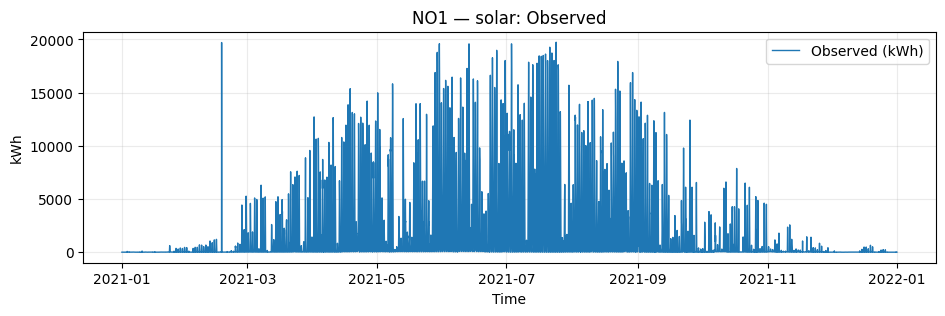

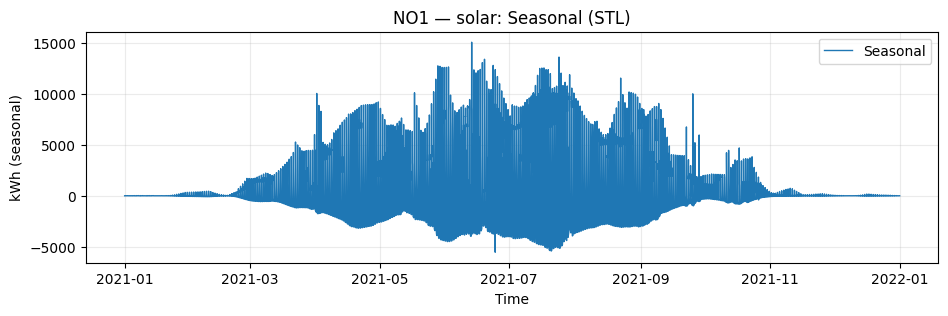

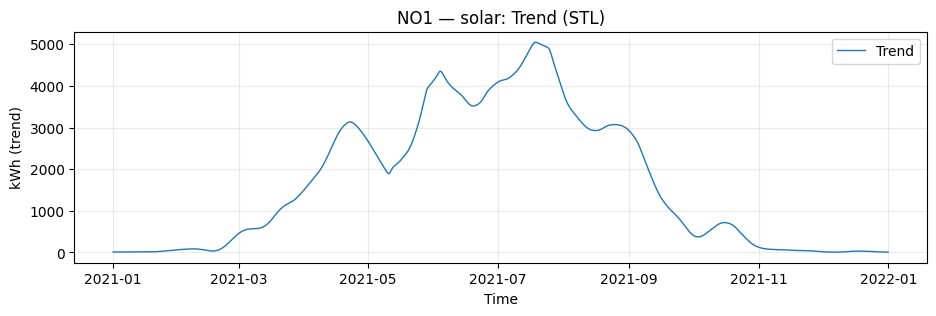

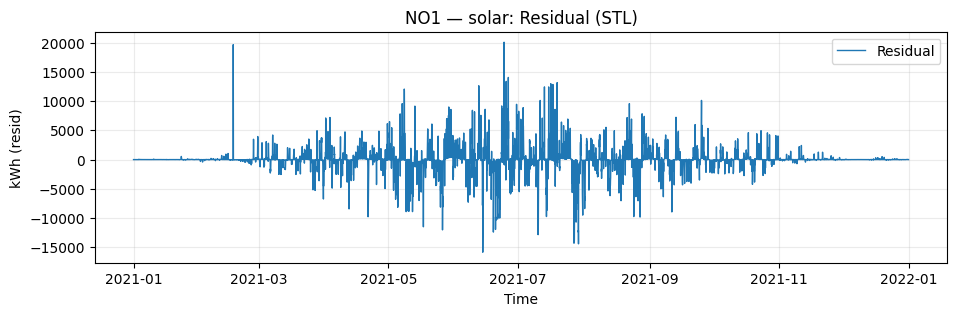

{'area': 'NO1',
 'group': 'solar',
 'period': 24,
 'seasonal': 13,
 'trend': 365,
 'robust': True,
 'n_points': 8760}

In [87]:
# Example STL decomposition for NO1 solar production
figs, details, filtered = stl_decompose_elhub(
    df_elhub,
    area="NO1",           
    group="solar",        
    period=24,
    seasonal=13,
    trend=365,
    robust=True
)

# Render the figures in our notebook:
for f in figs.values():
     plt.show(f)

details


In [99]:
# Spectrogram of Elhub production data (hourly)
def plot_production_spectrogram(
    df: pd.DataFrame,
    area: str = "NO1",
    group: str = "solar",
    window_len: int = 168,                # hours per window (default: 1 week for hourly data)
    overlap:   int = 84,                  # hours overlapped (default: 50%)
    time_col: str = "start_time",
    area_col: str = "price_area",
    group_col: str = "production_group",
    value_col: str = "quantity_kwh",
    detrend: str = "constant",            # 'constant' is a safe default to remove level offsets
    scaling: str = "density"              # 'density' gives units per Hz; 'spectrum' is raw power
):
    """
    Create and return a spectrogram figure for the selected area & group.
    Returns (fig, freqs, times, Sxx, series_used).
    """

    # Filter & prep series (hourly) 
    d = df[(df[area_col] == area) & (df[group_col] == group)].copy()
    if d.empty:
        raise ValueError(f"No data for area={area!r} and group={group!r}.")
    d[time_col] = pd.to_datetime(d[time_col])
    d = d.sort_values(time_col).set_index(time_col)


    # enforce hourly index; preserve totals (sum if duplicates)
    y = d[value_col].astype(float).resample("h").sum()


    # handle small gaps without inventing long periods of production
    # - interpolate short gaps up to 3 hours
    # - fill any remaining NaN with 0 (assume no production)
    y = y.asfreq("h")
    y = y.interpolate(method="time", limit=3)
    y = y.fillna(0.0)


    # sanity for window sizes
    if window_len <= 4 or window_len > len(y):
        raise ValueError("window_len must be between 5 and the series length.")
    if not (0 <= overlap < window_len):
        raise ValueError("overlap must be >=0 and < window_len.")


    # Spectrogram (SciPy) 
    fs = 1.0  # samples per hour
    f, t, Sxx = spectrogram(
        y.values,
        fs=fs,
        window="hann",
        nperseg=window_len,
        noverlap=overlap,
        detrend=detrend,
        scaling=scaling,
        mode="psd"  
    )


    # Convert spectrogram time bins to datetimes (relative to series start)
    t0 = y.index[0]
    t_dt = pd.to_datetime(t0) + pd.to_timedelta(t, unit="h")


    # Plot 
    fig, ax = plt.subplots(figsize=(11, 4.0))
    im = ax.pcolormesh(t_dt, f, Sxx, shading="gouraud")
    
    # Fixed monthly ticks 
    ax.xaxis.set_major_locator(mdates.MonthLocator(interval=2))   
    ax.xaxis.set_major_formatter(mdates.DateFormatter("%Y-%m"))
    fig.tight_layout()

    ax.set_ylabel("Frequency (cycles/hour)")
    ax.set_xlabel("Time")
    ax.set_title(f"Spectrogram — {area} / {group}  (nperseg={window_len}, overlap={overlap})")
    cbar = fig.colorbar(im, ax=ax)
    cbar.set_label("Power (PSD)")
    ax.set_ylim(0, 0.5)  # hide ultra-high frequencies 
    ax.grid(True, alpha=0.2)

    return fig, f, t_dt, Sxx, y



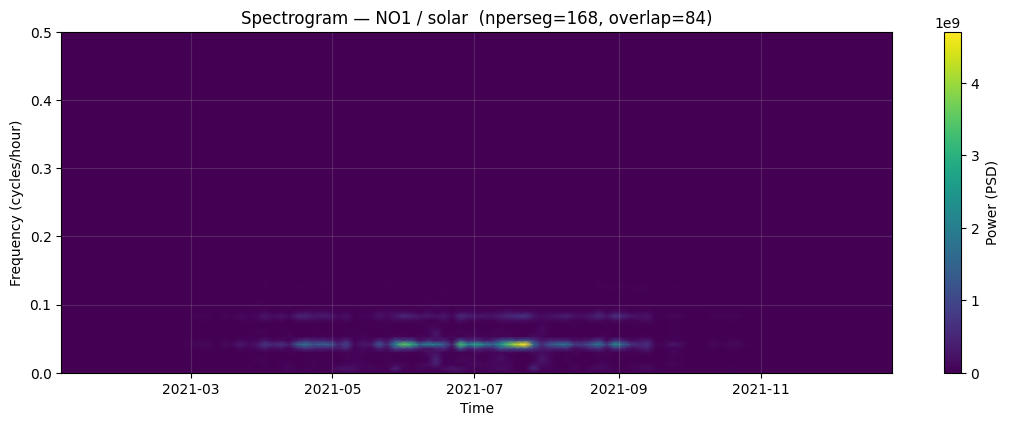

In [100]:
# Example Weekly spectrogram for NO1 solar production
fig_sp, freqs, times, Sxx, series_used = plot_production_spectrogram(
    df_elhub,
    area="NO1",
    group="solar",        
    window_len=168,       # weekly window
    overlap=84            # 50% overlap
)

plt.show(fig_sp)